In [44]:

def triangles(G: nx.Graph, nodes=None):
    """
    Algoritmo per il conteggio dei triangoli in un grafo indiretto, analizzato nel paper Fast Parallel For Counting
    and Listing Triangles in Big Graphs
    :param G: grafo indiretto della libreria networkx
    :param nodes: lista di nodi, l'algoritmo valuta per ognuno di questi se un triangolo incide su essi
    :return: numero di triangoli nel grafo G
    """
    if G.is_directed():
        raise ValueError('This algorithm work on undirected graph!')

    if nodes is None:
        nodes = G.nodes()
    neighbors = {node: set() for node in G.nodes()}
    # Si potrebbe utilizzare hash(id_n) per contenere la lunghezza dell'id
    ids = {node: id_n for id_n, node in enumerate(G.nodes())}
    triangles = 0

    for u, v in G.edges():
        if ids[u] < ids[v]:
            neighbors[u].add(v)
        if ids[u] > ids[v]:
            neighbors[v].add(u)

    for n in nodes:
        neighbors_n = neighbors[n]
        for v in neighbors_n:
            neighbors_v = neighbors[v]
            # Notiamo che i nodi w in comune tra il vicinato di n e v hanno un id più alto sia di n che di v.
            # Essendo v un nodo vicino ad n id(v) > id(n), quindi id(n)<id(v)<id(w)
            w = neighbors_n.intersection(neighbors_v)
            triangles += len(w)

    return triangles


In [142]:
import networkx as nx
import random
import math
from tqdm import tqdm
import numpy as np
def   GenWS2DG(n, r, k, q):
    G = nx.Graph()
    nodes=dict() #This will be used to associate to each node its coordinates
    prob=dict() #Keeps for each pair of nodes (u,v) the term 1/dist(u,v)**q
    pos = dict()

    # dim is the dimension of the area in which we assume nodes are placed.
    # Here, we assume that the 2D area has dimension sqrt(n) x sqrt(n).
    # Anyway, one may consider a larger or a smaller area.
    # E.g., if dim = 1 we assume that all features of a nodes are within [0,1].
    # However, recall that the radius r given in input must be in the same order of magnitude as the size of the area
    # (e.g., you cannot consider the area as being a unit square, and consider a radius 2, otherwise there will be an edge between each pair of nodes)
    # Hence, the choice of larger values for dim can be preferred if one want to represent r as an integer and not a floating point number
    dim = math.sqrt(n)
    strong_ties = 0
    weak_ties = 0
    strong_ties_list = []
    # The following for loop creates n nodes and place them randomly in the 2D area.
    # If one want to consider a different placement, e.g., for modeling communities, one only need to change this part.
    for i in range(n):
        x=random.random()
        y=random.random()
        nodes[i]=(x*dim,y*dim)
        prob[i]=dict()
        pos[i] = np.array([x*dim,y*dim])
      

    for i in tqdm(range(n)):
        # Strong-ties
        
        for j in range(i+1,n):
            # we add edge only towards next nodes,
            # since edge to previous nodes have been added when these nodes have been processed
            dist = math.sqrt((nodes[i][0]-nodes[j][0])**2 + (nodes[i][1]-nodes[j][1])**2) #Euclidean Distance
            prob[i][j] = 1/(dist**q)
            prob[j][i] = prob[i][j]
            if dist <= r:
                strong_ties+=1
                G.add_edge(i, j)
                strong_ties_list.append((i,j))
                G.edges[i,j]['color'] = 'black'
                
               

        # Terms 1/dist(u,v)**q are not probabilities since their sum can be different from 1.
        # To translate them in probabilities we normalize them, i.e, we divide each of them for their sum
        norm=sum(prob[i].values())
        # Weak ties
        for h in range(k):
            # They are not exactly h, since the random choice can return a node s such that edge (i, s) already exists
            # Next instruction allows to choice from the list given as first argument according to the probability distribution given as second argument
            s=np.random.choice([x for x in range(n) if x != i],p=[prob[i][x]/norm for x in range(n) if x != i])
            G.add_edge(i, s)
            if (i,s) not in strong_ties_list:
              G.edges[i,s]['color'] = 'green'
              weak_ties+=1
  
    return G,pos,strong_ties,weak_ties




In [6]:
import random
import math

def approximation_r(num_neighbors,n):
    nodes=dict()
    distances = []
    dim = math.sqrt(n)
    for i in range(n):
      x=random.random()
      y=random.random()
      nodes[i]=(x*dim,y*dim)
  
    node_labels = list(nodes.keys())
    i = random.choice(node_labels)
    for j in node_labels:
      if j != i:
        dist = math.sqrt((nodes[i][0]-nodes[j][0])**2 + (nodes[i][1]-nodes[j][1])**2) #Euclidean Distance
        distances.append(dist)
    dist_sort = sorted(distances)
    return dist_sort[num_neighbors - 1]
      



In [27]:
approximation_r(2,50)

0.660526118781896

# **Parametro r**

Il pametro **r** definisce il numero di strong-ties
Aumentando il numero di strong-ties aumentano anche il numero di triangoli, questo perchè aumenta la probabilità che 3 nodi vicini vengano collegati 

100%|██████████| 50/50 [00:00<00:00, 2700.08it/s]


Numero triangoli:  7  Coefficiente di clustering:  0.09085714285714286


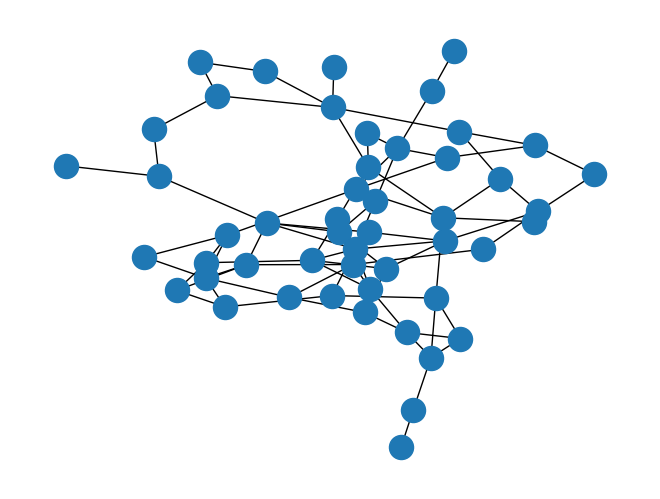

In [144]:
rlist = [0.1,0.5,10,20]
g1,_,_,_ = GenWS2DG(50, rlist[0], 2, 2)
nx.draw(g1)
print("Numero triangoli: ",triangles(g1)," Coefficiente di clustering: ",nx.average_clustering(g1))

# **Parametro k**

Il parametro **k** definisce il numero di weak-ties da creare ad ogni step. Maggiore è questo valore più basso sarà il diametro

100%|██████████| 40/40 [00:00<00:00, 412.20it/s]


Diametro:  3


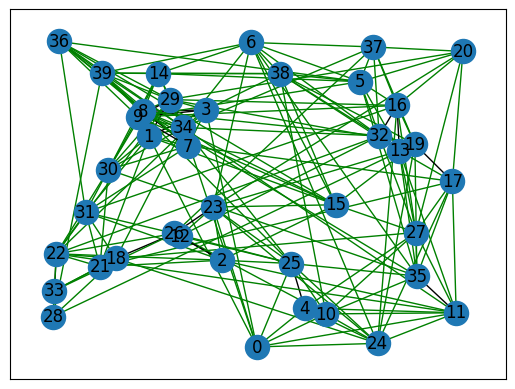

In [146]:
from networkx.algorithms.distance_regular import diameter
klist = [1,2,10] 
g2,pos,_,_ = GenWS2DG(40, 1, klist[2], 2)
edge_colors = [g2.edges[edge]["color"] for edge in g2.edges()]
nx.draw_networkx(g2, pos, edge_color=edge_colors, with_labels=True)
print("Diametro: ",nx.diameter(g2))

# **Parametro q**

Il prametro **q** regola la creazione dei weak-tie. Aumentando la q diminuisce la probabilità di creare un weak-tie

100%|██████████| 20/20 [00:00<00:00, 2653.62it/s]


Numero di weak-tie:  26


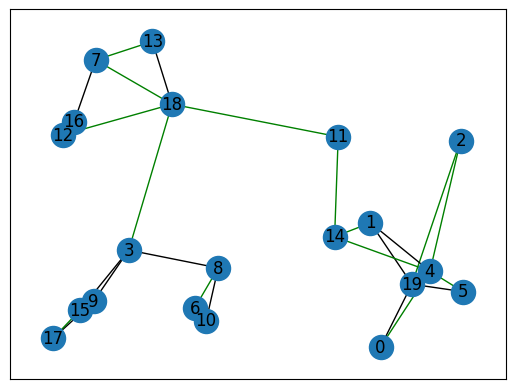

In [161]:
qlist = [1,4]
g2,pos,_,weak_ties = GenWS2DG(20, 1, 2, qlist[1])
edge_colors = [g2.edges[edge]["color"] for edge in g2.edges()]
nx.draw_networkx(g2, pos, edge_color=edge_colors, with_labels=True)
print("Numero di weak-tie: ",weak_ties)